In [ ]:
!pip3 install torchmetrics wandb torchattacks adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=8f700dbc24b5ab1a08bdb780e7febe4f345ff7d619c9dd3a1746198b4423929a
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153

In [ ]:
import warnings

warnings.simplefilter('ignore')
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchmetrics.classification import MulticlassAccuracy
import wandb

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# wandb.login()

if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

device = torch.device(device)

print(device)

In [ ]:
epoch_number = 100
batch_size = 256
lr = 0.0001

train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),  # FLips the image w.r.t horizontal axis
        transforms.RandomRotation(10),  #Rotates the image to a specified angel
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  #Performs actions like zooms, change shear angles.
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Set the color params
        transforms.Normalize(
            (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
        )
    ]
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
        )
    ]
)

train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
''' 
wandb библиотека нужна для рисования графиков обучения, loss и точности классификации на тестовых данных
'''
# # start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project='denis-dudakov',
#     name='VGG16_lrelu_adv_fgsm',

#     # track hyperparameters and run metadata
#     config={
#         "architecture": 'VGG16',
#         "dataset": "CIFAR-10",
#         "epochs": epoch_number,
#         'batch_size': batch_size,
#         'optimizer': 'Adam',
#         "learning_rate": lr,
#     }
# )


wandb: Currently logged in as: ddudakov02. Use `wandb login --relogin` to force relogin


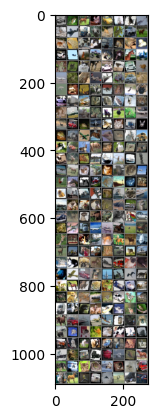

plane frog  horse cat   car   ship  dog   plane bird  plane truck bird  deer  bird  truck horse deer  frog  cat   cat   ship  frog  frog  dog   car   plane bird  truck frog  bird  horse plane frog  cat   cat   bird  truck bird  car   bird  plane frog  frog  plane plane frog  car   horse frog  cat   deer  horse cat   frog  bird  dog   car   truck plane cat   cat   ship  cat   cat   dog   plane truck deer  horse bird  bird  plane deer  car   frog  plane plane cat   truck cat   frog  truck plane dog   bird  dog   ship  truck dog   car   deer  horse dog   bird  deer  deer  truck deer  horse plane ship  bird  ship  cat   plane horse dog   frog  dog   truck frog  plane bird  horse horse car   cat   ship  car   dog   dog   truck truck cat   frog  ship  frog  ship  ship  frog  cat   horse frog  plane truck bird  car   deer  bird  deer  frog  cat   bird  car   frog  plane truck plane ship  horse bird  horse deer  horse cat   plane cat   deer  horse plane deer  truck horse cat   cat   bird  cat 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h


vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']


def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.LeakyReLU(inplace=True)]
            else:
                layers += [conv2d, nn.LeakyReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)


In [ ]:
model = VGG(get_vgg_layers(vgg16_config, batch_norm=True), 10)
model.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01, inplace=True)
    (1

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer,
    # step_size=30,
    milestones=[20, 35, 45],
    gamma=0.1
)


**Обучение началось**

In [ ]:
metric_accuracy = MulticlassAccuracy(num_classes=10, average='micro').to(device)
for epoch in range(epoch_number):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        accuracy = metric_accuracy(outputs, labels)
        wandb.log(
            {
                'train/accuracy': accuracy.item(),
                'train/loss': loss.item()
            }
        )

    # wandb.log({'train/learning_rate': optimizer.param_groups[0]['lr']})
    # scheduler.step()
    running_loss = 0.0

print('Finished Training')


Finished Training


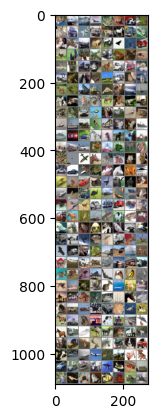

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
metric_accuracy = MulticlassAccuracy(num_classes=10, average='micro').to('cpu')

model.to('cpu')
# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs, _ = model(images)
        _, predictions = torch.max(outputs, 1)
        accuracy = metric_accuracy(outputs, labels)
        wandb.log({'test/accuracy': accuracy.item()})
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 82.3 %
Accuracy for class: car   is 89.3 %
Accuracy for class: bird  is 78.7 %
Accuracy for class: cat   is 65.1 %
Accuracy for class: deer  is 85.5 %
Accuracy for class: dog   is 67.7 %
Accuracy for class: frog  is 83.7 %
Accuracy for class: horse is 83.0 %
Accuracy for class: ship  is 90.5 %
Accuracy for class: truck is 89.8 %


**Обучение закончилось.
Мы будем ичпользовать уже обученные модели мной.**

In [ ]:
!pip install adversarial-robustness-toolbox torchmetrics wandb torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 27.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-p

In [ ]:
import warnings

warnings.simplefilter('ignore')
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchmetrics.classification import MulticlassAccuracy

from art.utils import load_mnist, load_cifar10
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, PixelAttack
from art.estimators.classification import PyTorchClassifier
from art.data_generators import PyTorchDataGenerator

from torchattacks.attacks.fgsm import FGSM
from torchattacks.attacks.pgd import PGD

SEED = 1234
batch_size = 256

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

device = torch.device(device)

print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),  # FLips the image w.r.t horizontal axis
        transforms.RandomRotation(10),  #Rotates the image to a specified angel
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  #Performs actions like zooms, change shear angles.
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Set the color params
        transforms.Normalize(
            (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
        )
    ]
)

transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)
'''
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)


'''
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 77466699.13it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


**LEAKYRELU**

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

class Wrapper_VGG(nn.Module):
  def __init__(
      self
      ,model
      ,tr = transforms.Normalize(
            (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
      )
  ):
    super().__init__()
    self.tr = tr
    self.model = model
  def forward(self, x):
    x = self.tr(x)
    x = self.model(x)
    return x[0]

In [ ]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.LeakyReLU(inplace=True)]
            else:
                layers += [conv2d, nn.LeakyReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [ ]:
import os

def load_weights(model, path):
    print(f'Загружаем модель из {path}')
    return model.load_state_dict(torch.load(path))

m_name = 'VGG16_lrelu_100_256_0001.pt'
s_path = '/content/drive/MyDrive/VGG_weights/VGG16_lrelu_100_256_0001.pt'
# save_path = os.path.join(s_path, m_name)
# torch.save(model.state_dict(), save_path)

model = VGG(get_vgg_layers(vgg16_config, batch_norm=True), 10)
model = model.to(device)

load_weights(model, s_path)

Загружаем модель из /content/drive/MyDrive/VGG_weights/VGG16_lrelu_100_256_0001.pt


<All keys matched successfully>

In [ ]:
def run_attack(model, attack, ds_loader):
    correct_pred = {classname: 0 for classname in classes}
    correct_pred_adv = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    total_pred_adv = {classname: 0 for classname in classes}
    metric_accuracy = MulticlassAccuracy(num_classes=10, average='micro').to(device)#.to('cpu')

    # model.to('cpu')
    # again no gradients needed
    # with torch.no_grad():
    for x, labels in ds_loader:
        x = x.to(device)
        labels = labels.to(device)

        x_adv = attack(x,labels)
        outputs = model(x)
        outputs_adv = model(x_adv)

        _, predictions = torch.max(outputs, 1)
        _, predictions_adv = torch.max(outputs_adv, 1)

        accuracy = metric_accuracy(outputs, labels)
        accuracy_adv = metric_accuracy(outputs_adv, labels)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
        for label, prediction in zip(labels, predictions_adv):
            if label == prediction:
                correct_pred_adv[classes[label]] += 1
            total_pred_adv[classes[label]] += 1

    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.2f} %')

    for classname, correct_count in correct_pred_adv.items():
        accuracy = 100 * float(correct_count) / total_pred_adv[classname]
        print(f'Accuracy adv for class: {classname:5s} is {accuracy:.2f} %')

In [ ]:
model_wr = Wrapper_VGG(model)
#attack = FGSM(model_wr, eps=8/255)

In [ ]:
attacker_FGSM =  FGSM(model = model_wr , eps= 0.03137254901960784 )
attacker_PGD = PGD(model = model_wr, eps=0.03137254901960784, alpha=0.00784313725490196, steps=5, random_start=True)

run_attack(model_wr, attacker_FGSM, test_loader )
run_attack(model_wr, attacker_PGD, test_loader )

Accuracy for class: plane is 90.10 %
Accuracy for class: car   is 92.20 %
Accuracy for class: bird  is 84.40 %
Accuracy for class: cat   is 71.40 %
Accuracy for class: deer  is 86.30 %
Accuracy for class: dog   is 82.30 %
Accuracy for class: frog  is 91.80 %
Accuracy for class: horse is 92.40 %
Accuracy for class: ship  is 94.60 %
Accuracy for class: truck is 94.40 %
Accuracy adv for class: plane is 13.50 %
Accuracy adv for class: car   is 18.90 %
Accuracy adv for class: bird  is 4.80 %
Accuracy adv for class: cat   is 1.00 %
Accuracy adv for class: deer  is 2.50 %
Accuracy adv for class: dog   is 1.30 %
Accuracy adv for class: frog  is 8.80 %
Accuracy adv for class: horse is 15.70 %
Accuracy adv for class: ship  is 32.90 %
Accuracy adv for class: truck is 11.40 %
Accuracy for class: plane is 90.60 %
Accuracy for class: car   is 92.60 %
Accuracy for class: bird  is 84.30 %
Accuracy for class: cat   is 72.50 %
Accuracy for class: deer  is 86.00 %
Accuracy for class: dog   is 82.60 %
Acc

**RELU**

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

class Wrapper_VGG(nn.Module):
  def __init__(
      self
      ,model
      ,tr = transforms.Normalize(
            (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
      )
  ):
    super().__init__()
    self.tr = tr
    self.model = model
  def forward(self, x):
    x = self.tr(x)
    x = self.model(x)
    return x[0]

In [ ]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [ ]:
m_name = 'VGG16_relu_100_256_0001.pt'
s_path = '/content/drive/MyDrive/VGG_weights/VGG16_relu_100_256_0001.pt'
# save_path = os.path.join(s_path, m_name)
# torch.save(model.state_dict(), save_path)

model = VGG(get_vgg_layers(vgg16_config, batch_norm=True), 10)
model = model.to(device)

load_weights(model, s_path)

Загружаем модель из /content/drive/MyDrive/VGG_weights/VGG16_relu_100_256_0001.pt


<All keys matched successfully>

In [ ]:
model_wr = Wrapper_VGG(model)
#attack = FGSM(model_wr, eps=8/255)

attacker_FGSM =  FGSM(model = model_wr , eps= 2/255 )
attacker_PGD = PGD(model = model_wr, eps=2/255, alpha=1/255, steps=5, random_start=True)

run_attack(model_wr, attacker_FGSM, test_loader )
run_attack(model_wr, attacker_PGD, test_loader )

Accuracy for class: plane is 90.50 %
Accuracy for class: car   is 91.60 %
Accuracy for class: bird  is 85.90 %
Accuracy for class: cat   is 76.20 %
Accuracy for class: deer  is 87.00 %
Accuracy for class: dog   is 78.50 %
Accuracy for class: frog  is 89.50 %
Accuracy for class: horse is 91.80 %
Accuracy for class: ship  is 93.80 %
Accuracy for class: truck is 94.30 %
Accuracy adv for class: plane is 53.50 %
Accuracy adv for class: car   is 61.10 %
Accuracy adv for class: bird  is 34.70 %
Accuracy adv for class: cat   is 16.60 %
Accuracy adv for class: deer  is 27.30 %
Accuracy adv for class: dog   is 28.50 %
Accuracy adv for class: frog  is 40.60 %
Accuracy adv for class: horse is 56.40 %
Accuracy adv for class: ship  is 60.40 %
Accuracy adv for class: truck is 66.50 %
Accuracy for class: plane is 91.30 %
Accuracy for class: car   is 91.70 %
Accuracy for class: bird  is 86.70 %
Accuracy for class: cat   is 76.60 %
Accuracy for class: deer  is 87.60 %
Accuracy for class: dog   is 78.30 

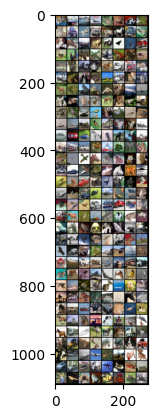

GroundTruth:  cat   ship  ship  plane


NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# functions to show an image
model = VGG(get_vgg_layers(vgg16_config, batch_norm=True), 10)
model = model.to(device)
model_wr = Wrapper_VGG(model)

def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


model_wr.to('cpu')
# again no gradients needed
# with torch.no_grad():
for x, labels in test_loader:
    x = x.to('cpu')#.to(device)
    labels = labels.to('cpu')#.to(device)

    x_adv = attacker_FGSM(x,labels)
    x_adv = x_adv.to('cpu')
    outputs = model_wr(x)
    outputs_adv = model_wr(x_adv)
    imshow(torchvision.utils.make_grid(x_adv))
    print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
    _, predictions = torch.max(outputs, 1)
    _, predictions_adv = torch.max(outputs_adv, 1)

    accuracy = metric_accuracy(outputs, labels)
    accuracy_adv = metric_accuracy(outputs_adv, labels)
    # # collect the correct predictions for each class
    # for label, prediction in zip(labels, predictions):
    #     if label == prediction:
    #             correct_pred[classes[label]] += 1
    #         total_pred[classes[label]] += 1
    #     for label, prediction in zip(labels, predictions_adv):
    #         if label == prediction:
    #             correct_pred_adv[classes[label]] += 1
    #         total_pred_adv[classes[label]] += 1

    # for classname, correct_count in correct_pred.items():
    #     accuracy = 100 * float(correct_count) / total_pred[classname]
    #     print(f'Accuracy for class: {classname:5s} is {accuracy:.2f} %')

    # for classname, correct_count in correct_pred_adv.items():
    #     accuracy = 100 * float(correct_count) / total_pred_adv[classname]
    #     print(f'Accuracy adv for class: {classname:5s} is {accuracy:.2f} %')

**SIGMOID**


In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096), 
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

class Wrapper_VGG(nn.Module):
  def __init__(
      self
      ,model
      ,tr = transforms.Normalize(
            (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
      )
  ):
    super().__init__()
    self.tr = tr
    self.model = model
  def forward(self, x):
    x = self.tr(x)
    x = self.model(x)
    return x[0]

vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.Sigmoid()]
            else:
                layers += [conv2d, nn.Sigmoid()]
            in_channels = c

    return nn.Sequential(*layers)

In [ ]:
m_name = 'VGG16_sigmoid_100_256_0001.pt'
s_path = '/content/drive/MyDrive/VGG_weights/VGG16_sigmoid_100_256_0001.pt'
# save_path = os.path.join(s_path, m_name)
# torch.save(model.state_dict(), save_path)

model = VGG(get_vgg_layers(vgg16_config, batch_norm=True), 10)
model = model.to(device)

load_weights(model, s_path)

Загружаем модель из /content/drive/MyDrive/VGG_weights/VGG16_sigmoid_100_256_0001.pt


<All keys matched successfully>

In [ ]:
model_wr = Wrapper_VGG(model)
#attack = FGSM(model_wr, eps=8/255)

attacker_FGSM =  FGSM(model = model_wr , eps= 1/255)
attacker_PGD = PGD(model = model_wr, eps=4/255, alpha=1/255, steps=5, random_start=True)

run_attack(model_wr, attacker_FGSM, test_loader )
run_attack(model_wr, attacker_PGD, test_loader )

Accuracy for class: plane is 82.30 %
Accuracy for class: car   is 84.70 %
Accuracy for class: bird  is 71.10 %
Accuracy for class: cat   is 55.60 %
Accuracy for class: deer  is 84.80 %
Accuracy for class: dog   is 60.00 %
Accuracy for class: frog  is 72.50 %
Accuracy for class: horse is 83.10 %
Accuracy for class: ship  is 88.70 %
Accuracy for class: truck is 88.60 %
Accuracy adv for class: plane is 42.30 %
Accuracy adv for class: car   is 60.90 %
Accuracy adv for class: bird  is 27.60 %
Accuracy adv for class: cat   is 9.70 %
Accuracy adv for class: deer  is 32.20 %
Accuracy adv for class: dog   is 20.20 %
Accuracy adv for class: frog  is 31.40 %
Accuracy adv for class: horse is 49.50 %
Accuracy adv for class: ship  is 62.10 %
Accuracy adv for class: truck is 61.70 %
Accuracy for class: plane is 82.60 %
Accuracy for class: car   is 84.20 %
Accuracy for class: bird  is 70.00 %
Accuracy for class: cat   is 54.20 %
Accuracy for class: deer  is 84.70 %
Accuracy for class: dog   is 59.30 %

**TANH**

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096), 
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

class Wrapper_VGG(nn.Module):
  def __init__(
      self
      ,model
      ,tr = transforms.Normalize(
            (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
      )
  ):
    super().__init__()
    self.tr = tr
    self.model = model
  def forward(self, x):
    x = self.tr(x)
    x = self.model(x)
    return x[0]

vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.Tanh()]
            else:
                layers += [conv2d, nn.Tanh()]
            in_channels = c

    return nn.Sequential(*layers)

In [ ]:
m_name = 'VGG16_tanh_100_256_0001.pt'
s_path = '/content/drive/MyDrive/VGG_weights/VGG16_tanh_100_256_0001.pt'
# save_path = os.path.join(s_path, m_name)
# torch.save(model.state_dict(), save_path)

model = VGG(get_vgg_layers(vgg16_config, batch_norm=True), 10)
model = model.to(device)

load_weights(model, s_path)

Загружаем модель из /content/drive/MyDrive/VGG_weights/VGG16_tanh_100_256_0001.pt


<All keys matched successfully>

In [ ]:
model_wr = Wrapper_VGG(model)
#attack = FGSM(model_wr, eps=8/255)

attacker_FGSM =  FGSM(model = model_wr , eps= 1/255 )
attacker_PGD = PGD(model = model_wr, eps=4/255, alpha=1/255, steps=5, random_start=True)

run_attack(model_wr, attacker_FGSM, test_loader )
run_attack(model_wr, attacker_PGD, test_loader )

Accuracy for class: plane is 82.50 %
Accuracy for class: car   is 89.50 %
Accuracy for class: bird  is 78.90 %
Accuracy for class: cat   is 64.60 %
Accuracy for class: deer  is 86.00 %
Accuracy for class: dog   is 67.60 %
Accuracy for class: frog  is 84.20 %
Accuracy for class: horse is 83.20 %
Accuracy for class: ship  is 89.50 %
Accuracy for class: truck is 90.00 %
Accuracy adv for class: plane is 45.50 %
Accuracy adv for class: car   is 66.90 %
Accuracy adv for class: bird  is 36.00 %
Accuracy adv for class: cat   is 19.80 %
Accuracy adv for class: deer  is 41.00 %
Accuracy adv for class: dog   is 28.70 %
Accuracy adv for class: frog  is 48.60 %
Accuracy adv for class: horse is 54.50 %
Accuracy adv for class: ship  is 66.70 %
Accuracy adv for class: truck is 62.20 %
Accuracy for class: plane is 82.30 %
Accuracy for class: car   is 89.50 %
Accuracy for class: bird  is 79.10 %
Accuracy for class: cat   is 64.40 %
Accuracy for class: deer  is 85.70 %
Accuracy for class: dog   is 67.30 

**SOFTPLUS**

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.Softplus(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096), 
            nn.Softplus(),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

class Wrapper_VGG(nn.Module):
  def __init__(
      self
      ,model
      ,tr = transforms.Normalize(
            (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
      )
  ):
    super().__init__()
    self.tr = tr
    self.model = model
  def forward(self, x):
    x = self.tr(x)
    x = self.model(x)
    return x[0]

vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.Softplus()]
            else:
                layers += [conv2d, nn.Softplus()]
            in_channels = c

    return nn.Sequential(*layers)

In [ ]:
m_name = 'VGG16_softplus_100_256_0001.pt'
s_path = '/content/drive/MyDrive/VGG_weights/VGG16_softplus_100_256_0001.pt'
# save_path = os.path.join(s_path, m_name)
# torch.save(model.state_dict(), save_path)

model = VGG(get_vgg_layers(vgg16_config, batch_norm=True), 10)
model = model.to(device)

load_weights(model, s_path)

Загружаем модель из /content/drive/MyDrive/VGG_weights/VGG16_softplus_100_256_0001.pt


<All keys matched successfully>

In [ ]:
model_wr = Wrapper_VGG(model)
#attack = FGSM(model_wr, eps=8/255)

attacker_FGSM =  FGSM(model = model_wr , eps= 0.03137254901960784 )
attacker_PGD = PGD(model = model_wr, eps=0.03137254901960784, alpha=0.00784313725490196, steps=5, random_start=True)

run_attack(model_wr, attacker_FGSM, test_loader )
run_attack(model_wr, attacker_PGD, test_loader )

Accuracy for class: plane is 89.20 %
Accuracy for class: car   is 95.20 %
Accuracy for class: bird  is 85.70 %
Accuracy for class: cat   is 75.30 %
Accuracy for class: deer  is 87.20 %
Accuracy for class: dog   is 84.30 %
Accuracy for class: frog  is 88.80 %
Accuracy for class: horse is 91.50 %
Accuracy for class: ship  is 91.50 %
Accuracy for class: truck is 89.20 %
Accuracy adv for class: plane is 1.80 %
Accuracy adv for class: car   is 5.70 %
Accuracy adv for class: bird  is 1.80 %
Accuracy adv for class: cat   is 0.10 %
Accuracy adv for class: deer  is 0.20 %
Accuracy adv for class: dog   is 0.10 %
Accuracy adv for class: frog  is 0.70 %
Accuracy adv for class: horse is 2.50 %
Accuracy adv for class: ship  is 7.10 %
Accuracy adv for class: truck is 1.00 %
Accuracy for class: plane is 90.40 %
Accuracy for class: car   is 95.30 %
Accuracy for class: bird  is 84.90 %
Accuracy for class: cat   is 75.90 %
Accuracy for class: deer  is 87.70 %
Accuracy for class: dog   is 83.70 %
Accuracy